# Example of YAP Quantification

Here we present the second of three examples that cover the main analyses performed in the paper. As illustrative cases of study, we use a representative gastruloid dataset to demonstrate the full analysis pipeline, from raw data processing to the extraction of quantitative readouts. The steps shown in this second example are the following: 

- Nucleus Segmentation and debris removal.
- Whole cell segmentation and debris removal.
- YAP background quantification.
- Cell classification.
- YAP N/C quantification.

This second example focuses on the quantification of YAP by computing the per cell Nucleus to Cytoplas (N/C) ratio. Dendisy, neighborhood composition and radial distribution of cells are considered on `example1.ipynb` whereas p53 quantification is considered on `example3.ipynb`

### Nucleus Segmentation

First step of the analysis is to performed the segmentation using the `qlivecell`. For more information on that software visit it's github page. Conversely to what was shown in example 1, in this case segmentation relies on Cellpose, more precisely on the pretrained Cellpose model `cyto3`. Let's load the relevant packages and the Cellpose model.

In [1]:
### LOAD PACKAGE ###
from qlivecell import cellSegTrack, check_or_create_dir, fill_channels

# Set progress to false to not overflow with text the notebook.
import qlivecell.config as cfg
cfg.PROGRESS = False

### LOAD CELLPOSE MODEL ###
from cellpose import models
model = models.CellposeModel(gpu=True, model_type='cyto3')

/home/pablo/.pyenv/versions/qlc/lib/python3.9/site-packages/cellpose/resnet_torch.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map

Next, the user must define the direct path to this example folder:

In [ ]:
### PATH TO THE EXAMPLES FOLDER ###
PATH = "path/to/examples/"

With this, we can define the file to which we want to segment and create a folder to store the segmentation results.

In [3]:
path_to_data = PATH+"gastruloid2.tif"
path_to_results = PATH+"results_example2/"
check_or_create_dir(path_to_results)
path_to_save = path_to_results+"segmentation"
check_or_create_dir(path_to_save)

Next, we must define the segmentation, concatenation and batch arguments. For the segmentation we use Cellpose. For the nucleus segmentation we use the DAPI channel, thus the Cellpose channel argument is set to `[DAPI_channel, 0]`. Also, we found that a Cellpose `diameter` of 200 works well for this dataset. For this particular example we will not use 3D concatenation. The reason for this is that consecutive z planes where imaged 15µm apart, which makes it rare to have the cytoplasm and nucleus of a cell represented on two consecutive planes. Batch settings mainly define the format of the file (.tif in this case) and the main channel of the dataset which is to compute cell centroid.

In [4]:
channel_names = ["A12", "GPI-GFP", "YAP", "DAPI"]
ch_nuc = channel_names.index("DAPI")

segmentation_args={
'method': 'cellpose2D', 
'model': model, 
'blur': None, 
'channels': [ch_nuc+1, 0],
'diameter': 200,
}

concatenation3D_args = {
    'do_3Dconcatenation':False
}

batch_args = {
    'name_format':"ch"+str(ch_nuc)+"_{}",
    'extension':".tif",
}

We define the file to which we want to segment and create a folder to store the segmentation results

In [5]:
path_to_save = path_to_results+"segmentation"
check_or_create_dir(path_to_save)

Before running the segmentation, for this particular case, we use the debris threshold used on the previous example, as the size of the cells is similar.

In [6]:
size_th_nucleus = 36.0 #µm

With this, we can initialize the `cellSegTrack` object which handle the segmentation, run the segmentation and remove the segmented debris.

In [7]:
chans = fill_channels(ch_nuc, channel_names=channel_names)
CT_nuc = cellSegTrack(
    path_to_data,
    path_to_save,
    segmentation_args=segmentation_args,
    concatenation3D_args=concatenation3D_args,
    batch_args=batch_args,
    channels=chans
)
CT_nuc.run()

labs_to_rem = []
for cell in CT_nuc.jitcells:
    zc = int(cell.centers[0][0])
    zcid = cell.zs[0].index(zc)

    mask = cell.masks[0][zcid]
    area = len(mask) * CT_nuc.metadata["XYresolution"]**2
    if area < size_th_nucleus:
        labs_to_rem.append(cell.label)
    
for lab in labs_to_rem:
    CT_nuc._del_cell(lab)  

CT_nuc.update_labels()


###############           INIT ON BATCH MODE          ################
#                                                                    #
#   path to data = /home/pablo/Desktop/papers/GastruloidCompetition_paper/cell_competition_gastruloids/image-analysis/examples/gastruloid2.tif
#   path to save = /home/pablo/Desktop/papers/GastruloidCompetition_paper/cell_competition_gastruloids/image-analysis/examples/results_example2/segmentation/
#                                                                    #
#   No tracking method provided. Using greedy algorithm (if needed)  #
#                                                                    #
#   No time step provided, using 1 minute.                           #
#                                                                    #
###############          BEGIN SEGMENTATIONS          ################
#                                                                    #
#                                                          

### Whole Cell Segmentation

Once the nuclei are segmented, we do the same for the whole cell. In this case, the channels used for the segmentation are the GPI-GFP as the main segmentation channel and the DAPI as the secondary, nuclear channel. In this case, we increased the Cellpose `diameter` argument to 240. Also, we increased the debris threshold to 50 µm. Dapi is still used as the reference channel on `qlivecell` as we want it to be used for centroid computation and not the GPI-GFP membrane label.

In [8]:
size_th_whole = 50.0 #µm

channel_names = ["A12", "GPI-GFP", "YAP", "DAPI"]
ch_mem = channel_names.index("GPI-GFP")

segmentation_args={
'method': 'cellpose2D', 
'model': model, 
'blur': None, 
'channels': [ch_mem+1,ch_nuc+1],
'diameter': 240,
}

concatenation3D_args = {
    'do_3Dconcatenation':False
}

batch_args = {
    'name_format':"ch"+str(ch_mem)+"_{}",
    'extension':".tif",
}

chans = fill_channels(ch_nuc, channel_names=channel_names)
CT_whole = cellSegTrack(
    path_to_data,
    path_to_save,
    segmentation_args=segmentation_args,
    concatenation3D_args=concatenation3D_args,
    batch_args=batch_args,
    channels=chans
)
CT_whole.run()

labs_to_rem = []
for cell in CT_whole.jitcells:
    zc = int(cell.centers[0][0])
    zcid = cell.zs[0].index(zc)

    mask = cell.masks[0][zcid]
    area = len(mask) * CT_whole.metadata["XYresolution"]**2
    if area < size_th_whole:
        labs_to_rem.append(cell.label)
    
for lab in labs_to_rem:
    CT_whole._del_cell(lab)  

CT_whole.update_labels()


###############           INIT ON BATCH MODE          ################
#                                                                    #
#   path to data = /home/pablo/Desktop/papers/GastruloidCompetition_paper/cell_competition_gastruloids/image-analysis/examples/gastruloid2.tif
#   path to save = /home/pablo/Desktop/papers/GastruloidCompetition_paper/cell_competition_gastruloids/image-analysis/examples/results_example2/segmentation/
#                                                                    #
#   No tracking method provided. Using greedy algorithm (if needed)  #
#                                                                    #
#   No time step provided, using 1 minute.                           #
#                                                                    #
###############          BEGIN SEGMENTATIONS          ################
#                                                                    #
#                                                          

### Background substraction

Now that we have the whole cells and the nuclei segmented, we used a YAP secondary antibody only staining to compute the background from both compartments. The pipelive for that starts similarly as what has been described above, we segment the nuclei and the whole cell and remove objects by size. 

In [9]:
path_to_data_background = PATH+"gastruloid2_background.tif"
path_to_results_background = PATH+"results_example2_background/"
check_or_create_dir(path_to_results_background)
path_to_save_background = path_to_results_background+"segmentation"
check_or_create_dir(path_to_save_background)

segmentation_args={
'method': 'cellpose2D', 
'model': model, 
'blur': None, 
'channels': [ch_nuc+1, 0],
'diameter': 200,
}

batch_args = {
    'name_format':"ch"+str(ch_nuc)+"_{}",
    'extension':".tif",
}

chans = fill_channels(ch_nuc, channel_names=channel_names)
CT_nuc_background = cellSegTrack(
    path_to_data_background,
    path_to_save_background,
    segmentation_args=segmentation_args,
    concatenation3D_args=concatenation3D_args,
    batch_args=batch_args,
    channels=chans
)
CT_nuc_background.run()

labs_to_rem = []
for cell in CT_nuc_background.jitcells:
    zc = int(cell.centers[0][0])
    zcid = cell.zs[0].index(zc)

    mask = cell.masks[0][zcid]
    area = len(mask) * CT_nuc_background.metadata["XYresolution"]**2
    if area < size_th_nucleus:
        labs_to_rem.append(cell.label)
    
for lab in labs_to_rem:
    CT_nuc_background._del_cell(lab)  

CT_nuc_background.update_labels()

segmentation_args={
'method': 'cellpose2D', 
'model': model, 
'blur': None, 
'channels': [ch_mem+1, ch_nuc+1],
'diameter': 240,
}

batch_args = {
    'name_format':"ch"+str(ch_mem)+"_{}",
    'extension':".tif",
}

chans = fill_channels(ch_nuc, channel_names=channel_names)
CT_whole_background = cellSegTrack(
    path_to_data_background,
    path_to_save_background,
    segmentation_args=segmentation_args,
    concatenation3D_args=concatenation3D_args,
    batch_args=batch_args,
    channels=chans
)
CT_whole_background.run()

labs_to_rem = []
for cell in CT_whole_background.jitcells:
    zc = int(cell.centers[0][0])
    zcid = cell.zs[0].index(zc)

    mask = cell.masks[0][zcid]
    area = len(mask) * CT_whole_background.metadata["XYresolution"]**2
    if area < size_th_whole:
        labs_to_rem.append(cell.label)
    
for lab in labs_to_rem:
    CT_whole_background._del_cell(lab)  

CT_whole_background.update_labels()


###############           INIT ON BATCH MODE          ################
#                                                                    #
#   path to data = /home/pablo/Desktop/papers/GastruloidCompetition_paper/cell_competition_gastruloids/image-analysis/examples/gastruloid2_background.tif
#   path to save = /home/pablo/Desktop/papers/GastruloidCompetition_paper/cell_competition_gastruloids/image-analysis/examples/results_example2_background/segmentation/
#                                                                    #
#   No tracking method provided. Using greedy algorithm (if needed)  #
#                                                                    #
#   No time step provided, using 1 minute.                           #
#                                                                    #
###############          BEGIN SEGMENTATIONS          ################
#                                                                    #
#                                    

Once all the segmentations are done we can start computing the background values. The most direct is the nuclear background, which is computed as the mean YAP fluorescence inside the nuclear masks.

YAP nuclear background = 10210.83291275773


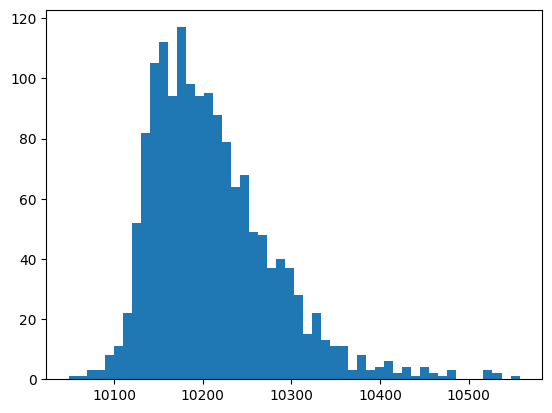

In [10]:
from qlivecell import tif_reader_5D
import numpy as np
import matplotlib.pyplot as plt

hyperstack_background, metadata = tif_reader_5D(path_to_data_background)

ch_yap = channel_names.index("YAP")

YAP_quant_nuc_background = []
for cell in CT_nuc_background.jitcells:
    z = int(cell.centers[0][0])
    mask = cell.masks[0][0]
    
    img = hyperstack_background[0,z, ch_yap]
    YAP_quant_nuc_background.append(np.mean(img[mask[:, 1], mask[:, 0]]))


YAP_nuc_back = np.mean(YAP_quant_nuc_background)
print("YAP nuclear background =", YAP_nuc_back)

fig, ax = plt.subplots()
ax.hist(YAP_quant_nuc_background, bins=50)
plt.show()

To define the cytoplasm we need to use the whole cell and nucleus segmentation. The cytoplasm is defined as the area of the whole cell segmentation minus the are of the nuclear mask. First, using a greedy tracking algorithm, we link masks segmented from both channels. Then, we curate that linkage using the following steps:

- Remove cells for which less than 95% of the nucleus is inside the whole cell mask.
- Remove cells for which the nucleus occupies less than 50% of the whole cell mask.
- Remove cells in which the final area of the cytoplasm is less than 10 pixels.

The remainning cells are used to compute the cytoplasmic YAP background.

YAP cytoplasmic background = 10284.2740789264


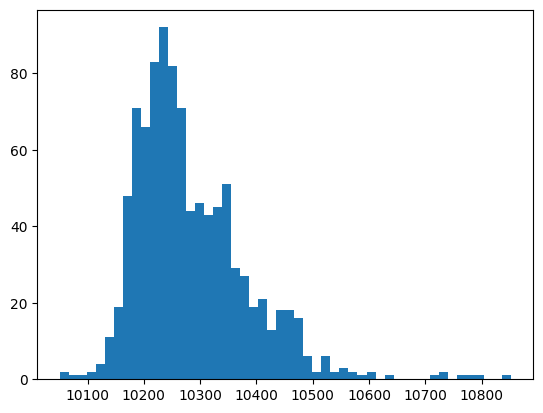

In [11]:
cyt_nuc_ratio = 0.95

YAP_quant_cyt_background = []
from qlivecell.celltrack.core.tracking.tracking import greedy_tracking

TLabels1 = [cell.label for cell in CT_whole_background.jitcells]
TLabels2 = [cell.label for cell in CT_nuc_background.jitcells]
TLabels  = [TLabels1, TLabels2]

TCenters1 = [cell.centers[0] for cell in CT_whole_background.jitcells]
TCenters2 = [cell.centers[0] for cell in CT_nuc_background.jitcells]
TCenters  = [TCenters1, TCenters2]

track_args = {
        "time_step": 1,
        "method": "greedy",
        "dist_th": 7.5,
        "z_th": 2,
    }

xyres = CT_nuc_background.metadata["XYresolution"]
zres = CT_nuc_background.metadata["Zresolution"]

FinalLabels, label_correspondance = greedy_tracking(TLabels, TCenters, xyres, zres, track_args, lab_max=0)

for lc in label_correspondance[1]:
    cell1 = CT_whole_background._get_cell(lc[1])
    if cell1==None:continue
    cell2 = CT_nuc_background._get_cell(lc[0])

    z = int(cell1.centers[0][0])
    mask1 = cell1.masks[0][0]
    mask2 = cell2.masks[0][0]
    
    # Assume: mask1 and mask2 are (N, 2) arrays of 2D points
    mask1_view = mask1.view(dtype=[('', mask1.dtype)] * mask1.shape[1])
    mask2_view = mask2.view(dtype=[('', mask2.dtype)] * mask2.shape[1])
    
    mask_coincidence = np.isin(mask2_view, mask1_view)
    mask_ratio = np.sum(mask_coincidence)/len(mask2)
    
    if mask_ratio < cyt_nuc_ratio: 
        continue
    
    if len(mask1)/2.0 > len(mask2):
        continue

    mask_coincidence_cyto = ~np.isin(mask1_view, mask2_view)
    cyto_mask = np.array([mask1[i] for i, j in enumerate(mask_coincidence_cyto) if j])
    img = hyperstack_background[0,z,ch_yap]
    YAP_quant_cyt_background.append(np.mean(img[cyto_mask[:, 1], cyto_mask[:, 0]]))

YAP_cyto_back = np.mean(YAP_quant_cyt_background)
print("YAP cytoplasmic background =", YAP_cyto_back)

fig, ax = plt.subplots()
ax.hist(YAP_quant_cyt_background, bins=50)
plt.show()

### Cell classification

Another step prior to the final YAP quantification is classifying cells into two populations. Similarly as in example 1, we have two populations of cells. However, in this case only one of them has a nulcear marker to differentiate them. We use that marker (emiRFP) to classify the cells into emiRFP positive (+) and emiRFP (-) cells and separate the posterior quantification as such.

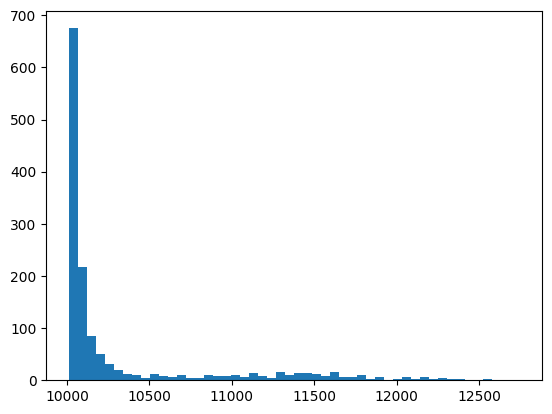

In [12]:
hyperstack, metadata = tif_reader_5D(path_to_data)

ch_RFP = channel_names.index("A12")
RFP_quant=[]
for cell in CT_nuc.jitcells:
    z = int(cell.centers[0][0])
    mask = cell.masks[0][0]
    
    img = hyperstack[0,z, ch_RFP]
    RFP_quant.append(np.mean(img[mask[:, 1], mask[:, 0]]))

fig, ax = plt.subplots()
ax.hist(RFP_quant, bins=50)
plt.show()

We decided that the best approach is to be conservative and set an upper and lower threshold which results in the loss of some cells, but the also the reduction of missclassifications. 

In [13]:
low_RFP_th = 10400
up_RFP_th  = 10600

### YAP N/C quantification

Finally, we can proceed with the YAP quantification as described above. As an extra step, we do a simple outlier removal using 2.5 times the Inter Quartile Range as threshold. First we will show an example of the cyt segmentation of a cell.

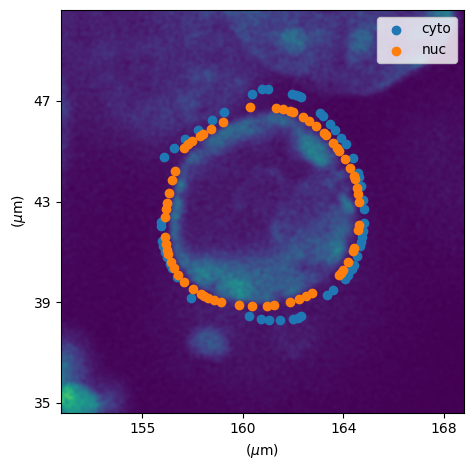

In [14]:

from scipy.spatial import ConvexHull
from scipy import stats

TLabels1 = [cell.label for cell in CT_whole.jitcells]
TLabels2 = [cell.label for cell in CT_nuc.jitcells]
TLabels  = [TLabels1, TLabels2]

TCenters1 = [cell.centers[0] for cell in CT_whole.jitcells]
TCenters2 = [cell.centers[0] for cell in CT_nuc.jitcells]
TCenters  = [TCenters1, TCenters2]

track_args = {
        "time_step": 1,
        "method": "greedy",
        "dist_th": 7.5,
        "z_th": 2,
    }

xyres = CT_nuc.metadata["XYresolution"]
zres = CT_nuc.metadata["Zresolution"]

FinalLabels, label_correspondance = greedy_tracking(TLabels, TCenters, xyres, zres, track_args, lab_max=0)

nuc_quant_file_F3 = []
cyt_quant_file_F3 = []
nuc_quant_file_A12 = []
cyt_quant_file_A12 = []

masks1 = []
masks2 = []
masks3 = []
zs = []
for lc in label_correspondance[1]:
    cell1 = CT_whole._get_cell(lc[1])
    if cell1==None:continue
    cell2 = CT_nuc._get_cell(lc[0])

    z = int(cell1.centers[0][0])
    mask1 = cell1.masks[0][0]
    mask2 = cell2.masks[0][0]
    # Assume: mask1 and mask2 are (N, 2) arrays of 2D points
    mask1_view = mask1.view(dtype=[('', mask1.dtype)] * mask1.shape[1])
    mask2_view = mask2.view(dtype=[('', mask2.dtype)] * mask2.shape[1])
        
    mask_coincidence = np.isin(mask2_view, mask1_view)
    mask_ratio = np.sum(mask_coincidence)/len(mask2)
    if mask_ratio < cyt_nuc_ratio: 
        continue
    
    if len(mask1)/2.0 > len(mask2):
        continue
        
    img = hyperstack[0,z,ch_yap]
    nuc_val = np.maximum(np.mean(img[mask2[:, 1], mask2[:, 0]]) - YAP_nuc_back, 0)

    img = hyperstack[0,z, ch_RFP]
    A12_val = np.mean(img[mask2[:, 1], mask2[:, 0]])

    mask_coincidence_cyto = np.isin(mask1_view, mask2_view)
    cyto_mask = np.array([mask1[i] for i, j in enumerate(mask_coincidence_cyto) if j])
    img = hyperstack[0,z,ch_yap]
    cyt_val = np.maximum(np.mean(img[cyto_mask[:, 1], cyto_mask[:, 0]]) - YAP_cyto_back, 0)

    if A12_val < low_RFP_th:
        nuc_quant_file_F3.append(nuc_val)
        cyt_quant_file_F3.append(cyt_val)
    elif A12_val >= up_RFP_th:
        nuc_quant_file_A12.append(nuc_val)
        cyt_quant_file_A12.append(cyt_val)

    masks1.append(mask1)
    masks2.append(mask2)
    zs.append(z)

F3_ratio = np.array(nuc_quant_file_F3)/cyt_quant_file_F3
A12_ratio = np.array(nuc_quant_file_A12)/cyt_quant_file_A12

def remove_outliers(data):
    # Calculate the first and third quartiles (Q1 and Q3)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 2.5 * IQR
    upper_bound = Q3 + 2.5 * IQR

    # Filter data to remove outliers
    return [x for x in data if lower_bound <= x <= upper_bound]

r = 200
cell = np.random.choice(range(len(masks1)))
img = hyperstack[0, zs[cell], ch_nuc]

mask1 = masks1[cell]
mask2 = masks2[cell]

hull = ConvexHull(mask1)
outline1 = mask1[hull.vertices]
outline1[:] = outline1[:, [1, 0]]

hull = ConvexHull(mask2)
outline2 = mask2[hull.vertices]
outline2[:] = outline2[:, [1, 0]]

center = np.mean(outline2, axis=0)

fig, ax = plt.subplots()
ax.imshow(img)

ax.scatter(outline1[:, 1], outline1[:, 0], label="cyto")
ax.scatter(outline2[:, 1], outline2[:, 0], label="nuc")

ax.set_xlabel("($\mu$m)")
ax.set_ylabel("($\mu$m)")

xticks = np.arange(0, img.shape[-1]-1, 100)
yticks = np.arange(0, img.shape[-1]-1, 100)

ax.set_xticks(xticks)
ax.set_yticks(yticks)

scale = metadata["XYresolution"]
ax.set_xticklabels([f"{x*scale:.0f}" for x in xticks])
ax.set_yticklabels([f"{y*scale:.0f}" for y in yticks])

ax.set_xlim(np.maximum(0, center[1]-r), np.minimum(img.shape[-1], center[1]+r))
ax.set_ylim(np.maximum(0, center[0]-r), np.minimum(img.shape[-1], center[0]+r))

ax.legend()
plt.tight_layout()
plt.show()


Finally, we can display the results of the N/C YAP quantification as a histogram per cell population.

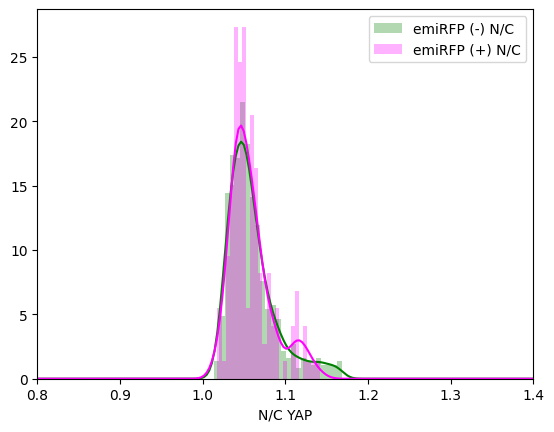

In [15]:
title = ""
bins=25

xx = np.linspace(0.2, 1.8, 500)

F3 = []
for val in F3_ratio:
    if not np.isnan(val) and not np.isinf(val):
        F3.append(val)

A12 = []
for val in A12_ratio:
    if not np.isnan(val) and not np.isinf(val):
        A12.append(val)
        
F3 = remove_outliers(F3)
kde_F3 = stats.gaussian_kde(F3)

A12 = remove_outliers(A12)
kde_A12 = stats.gaussian_kde(A12)

fig, ax = plt.subplots()
ax.hist(F3, label="emiRFP (-) N/C", alpha=0.3, bins=bins, color="green", density=True)
ax.plot(xx, kde_F3(xx), color="green")

ax.hist(A12, label="emiRFP (+) N/C", alpha=0.3, bins=bins, color="magenta", density=True)
ax.plot(xx, kde_A12(xx), color="magenta")

ax.set_xlim(0.8, 1.4)
ax.set_xlabel("N/C YAP")
ax.legend()
plt.show()

End of Notebook.